In [2]:
import pickle
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from sklearn.metrics import hamming_loss, accuracy_score
from collections import defaultdict
from scipy.linalg import subspace_angles

### Technically, I did stratified Kfold on the entire dataset, which is fine given some mixture of presentations of each stimulus, but I believe the most strong imbalance in the data (and most relevant) is the imbalance in corrupted vs clear faces. Thus, I should probably pass binary stim IDs for clear vs corrupted faces to KFold and split on that...

### Load consolidated decoding dataframe

In [4]:
decoding_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_decoding_med_batch/degraded_decoding_med_batch_glom.pickle'
with open(decoding_glom_path, 'rb') as f:
    dat_decode = pickle.load(f) 

df_decode = pd.DataFrame(dat_decode)

In [5]:
# Helpful ways to index / look at the df_decode
filtered_df_decode = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == 'AM') & (df_decode['dimreduc_method'] == 'PCA') ]
df_decode.columns

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'predictions', 'loss',
       'decoding_object', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'decoder',
       'decoder_args', 'thresholds', 'data_file', 'loader', 'loader_args',
       'task_args', 'data_path', 'results_file'],
      dtype='object')

In [6]:
data_path = df_decode['data_path']

#### Load the processed data as well for other info

In [5]:
preloaded_data_path = glob.glob(df_decode['data_path'][0] + "/preloaded/*.pickle")[1]
with open(preloaded_data_path, 'rb') as f:
    preload_dat = pickle.load(f) 


#### Get the stimIDs of degraded faces

In [6]:
stimNames = preload_dat["StimulusNames"]
degrade_types = ["blur", "contrast", "mooney_gray", "noise", "banana", "body", "bottle", "box", "rand1", "rand2"]
stimulus_ID_from_names = np.arange(1, len(stimNames)+1)

# LOAD FROM DATAFRAME DIRECT NOW
degraded_stim_inds = np.zeros(len(stimNames))
for idx, name in enumerate(stimNames):
    for deg in degrade_types:
        if deg in name:
            degraded_stim_inds[idx] = 1

degradedIDs = stimulus_ID_from_names[degraded_stim_inds.astype(bool)]


### Extract useful params and get average classification error 

In [10]:
degradedIDs = preload_dat['degradedIDs']
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_decode['dimreduc_method'])

In [11]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_losses = recursive_defaultdict()

for dr_method in dimreduc_methods:
    for reg in regions:
        all_losses[dr_method][reg] = np.zeros(len(dimensions))
        for idx, dim in enumerate(dimensions):

            df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim)]
            avg_loss = np.mean(df_decode_filt['loss']) # averages loss over k_fold splits
            all_losses[dr_method][reg][idx] = avg_loss

## Average classification accuracy in subspaces

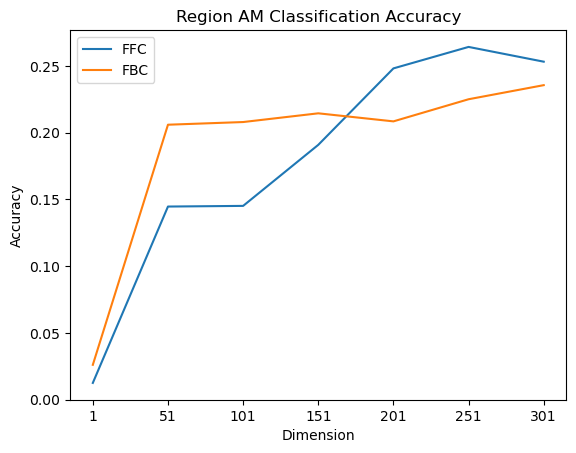

In [12]:
region = 'AM'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]

plt.plot(dimensions, FFC_losses, label="FFC")
plt.plot(dimensions, FBC_losses, label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


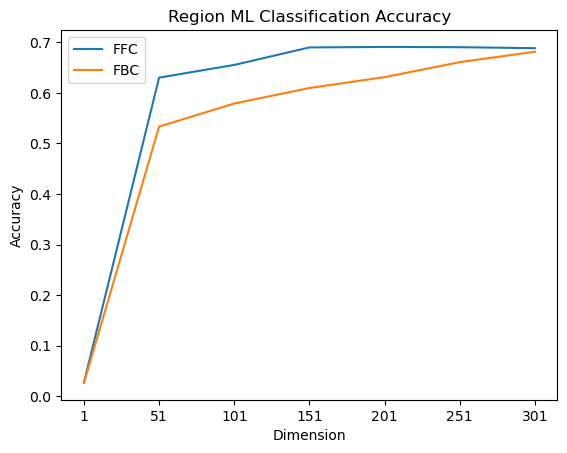

In [13]:
region = 'ML'

FFC_losses = 1 - all_losses['PCA'][region]
FBC_losses = 1 - all_losses['LQGCA'][region]

plt.plot(dimensions, FFC_losses, label="FFC")
plt.plot(dimensions, FBC_losses, label="FBC")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


## Average classificaiton accuracy on degraded vs clear faces

In [50]:
def recursive_defaultdict():
    return defaultdict(recursive_defaultdict)
all_type_accuracies = recursive_defaultdict()

for dr_method in dimreduc_methods:
    for reg in regions:
        for dim_idx, dim in enumerate(dimensions):

            degraded_accuracy = np.zeros(len(n_folds))
            clear_accuracy = np.zeros(len(n_folds))
            for n_fold in n_folds:

                df_decode_filt = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == reg) & 
                                        (df_decode['dimreduc_method'] == dr_method) & (df_decode['dim'] == dim) & (df_decode['fold_idx'] == n_fold)]
                

                pred_labels = df_decode_filt['predictions'].iloc[0]
                true_labels = df_decode_filt['Ytest'].iloc[0]

                # Might consider doing manual accuracy or something instead of loss

                # Accuracy on degraded trials 
                #print(  true_labels.values() )


                deg_trial_inds = np.where(np.isin(true_labels, degradedIDs))[0]
                true_deg_labels = true_labels[deg_trial_inds]
                pred_deg_labels = pred_labels[deg_trial_inds]
                deg_loss = accuracy_score(true_deg_labels, pred_deg_labels)
                degraded_accuracy[n_fold] = deg_loss


                # Accuracy on clear trials 
                clear_trial_inds = np.where(~np.isin(true_labels.astype(int), degradedIDs))[0]
                true_clear_labels = true_labels[clear_trial_inds]
                pred_clear_labels = pred_labels[clear_trial_inds]
                clear_loss = accuracy_score(true_clear_labels, pred_clear_labels)
                clear_accuracy[n_fold] = clear_loss

            all_type_accuracies[reg][dr_method]["deg"][dim_idx] = np.mean(degraded_accuracy)
            all_type_accuracies[reg][dr_method]["clear"][dim_idx] = np.mean(clear_accuracy)



In [46]:
FFC_deg_losses.values()

dict_values([0.01378502712709831, 0.14276857191168996, 0.14608951241937426, 0.19900876465524248, 0.24910886125492157, 0.267768544887355, 0.2612261087194204])

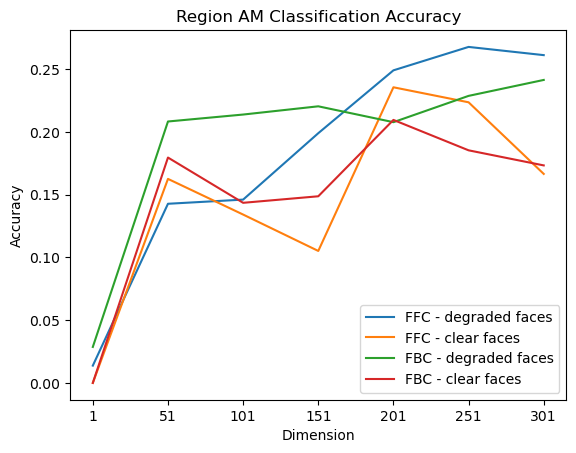

In [51]:
region = 'AM'

FFC_deg_losses = all_type_accuracies[region]['PCA']['deg'].values()
FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()

FBC_deg_losses = all_type_accuracies[region]['LQGCA']['deg'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()


plt.plot(dimensions, FFC_deg_losses, label="FFC - degraded faces")
plt.plot(dimensions, FFC_clear_losses, label="FFC - clear faces")
plt.plot(dimensions, FBC_deg_losses, label="FBC - degraded faces")
plt.plot(dimensions, FBC_clear_losses, label="FBC - clear faces")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


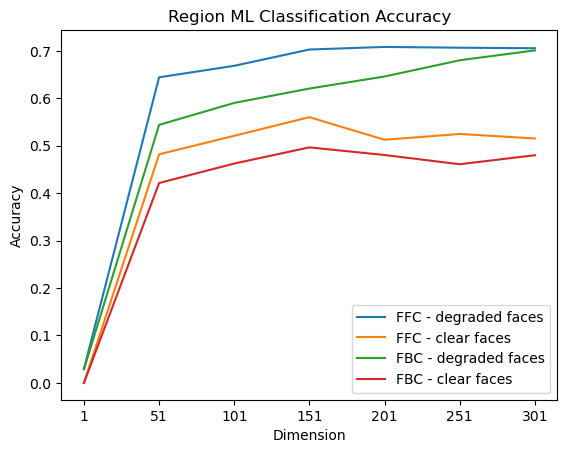

In [52]:
region = 'ML'

FFC_deg_losses = all_type_accuracies[region]['PCA']['deg'].values()
FFC_clear_losses = all_type_accuracies[region]['PCA']['clear'].values()

FBC_deg_losses = all_type_accuracies[region]['LQGCA']['deg'].values()
FBC_clear_losses = all_type_accuracies[region]['LQGCA']['clear'].values()


plt.plot(dimensions, FFC_deg_losses, label="FFC - degraded faces")
plt.plot(dimensions, FFC_clear_losses, label="FFC - clear faces")
plt.plot(dimensions, FBC_deg_losses, label="FBC - degraded faces")
plt.plot(dimensions, FBC_clear_losses, label="FBC - clear faces")

plt.legend()
plt.title(f'Region {region} Classification Accuracy')
plt.xticks(dimensions)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.show()


### Instead of manually filtering the dict can use Ankit's apply_df_filters call (might be tricky with dimreduc_args, but also maybe not)

In [ ]:
sabes_df = pd.DataFrame(sabes_df)

DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(sabes_df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)